<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png", width=300, height=300></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде - "яблоки и груши":

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv("./data/apples_pears.csv")

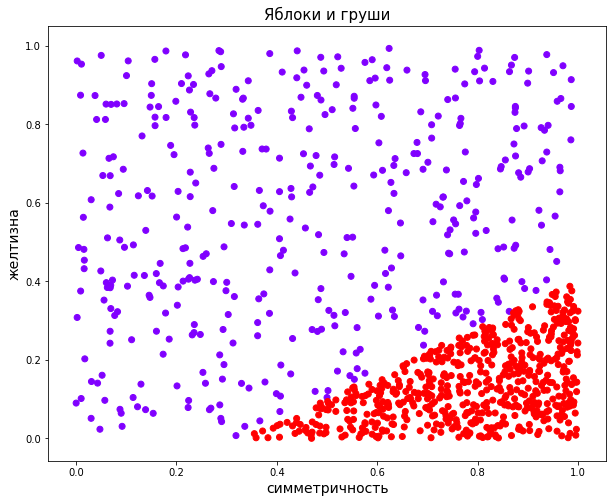

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [5]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [6]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);  ***

Рассмотрим второй путь (он чуть более user-friendly), к первому потом ещё вернёмся, и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [8]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [9]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [10]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.2966], grad_fn=<SigmoidBackward>)

Предскажем ещё необученным нейроном:

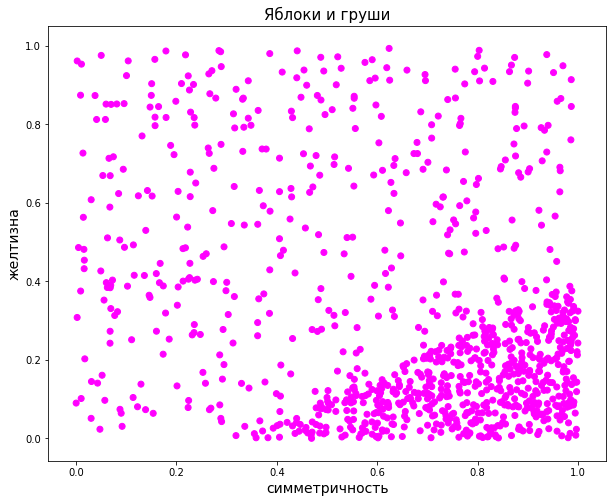

In [11]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [13]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [17]:
# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(reduction='sum')

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 215.75172424316406
1 206.5496368408203
2 199.7950897216797
3 194.63641357421875
4 190.49627685546875
5 187.00656127929688
6 183.9392547607422
7 181.15472412109375
8 178.56759643554688
9 176.12545776367188
10 173.7958221435547
11 171.5582733154297
12 169.39968872070312
13 167.31138610839844
14 165.28741455078125
15 163.32347106933594
16 161.416259765625
17 159.56314086914062
18 157.76185607910156
19 156.01040649414062
20 154.3069610595703
21 152.6498260498047
22 151.0373992919922
23 149.46812438964844
24 147.94052124023438
25 146.4531707763672
26 145.00469970703125
27 143.59378051757812
28 142.21913146972656
29 140.87953186035156
30 139.57376098632812
31 138.30067443847656
32 137.05918884277344
33 135.84820556640625
34 134.66671752929688
35 133.5137176513672
36 132.38824462890625
37 131.28939819335938
38 130.21629333496094
39 129.16807556152344
40 128.14393615722656
41 127.14307403564453
42 126.16473388671875
43 125.20819854736328
44 124.27275848388672
45 123.35774230957031
46 122.462

389 54.68801498413086
390 54.63620376586914
391 54.58458709716797
392 54.533164978027344
393 54.481929779052734
394 54.430885314941406
395 54.38003158569336
396 54.32936477661133
397 54.27888488769531
398 54.22858810424805
399 54.17847442626953
400 54.128543853759766
401 54.078800201416016
402 54.029232025146484
403 53.9798469543457
404 53.93063735961914
405 53.8816032409668
406 53.83274841308594
407 53.7840690612793
408 53.735565185546875
409 53.68722915649414
410 53.639068603515625
411 53.59107971191406
412 53.54326248168945
413 53.495609283447266
414 53.448123931884766
415 53.40081024169922
416 53.353660583496094
417 53.30667495727539
418 53.259849548339844
419 53.213191986083984
420 53.16669845581055
421 53.120365142822266
422 53.07419204711914
423 53.028175354003906
424 52.98231506347656
425 52.936614990234375
426 52.891075134277344
427 52.84568786621094
428 52.800453186035156
429 52.755374908447266
430 52.71044921875
431 52.665672302246094
432 52.62105178833008
433 52.57658004760

In [27]:
import torch
from torch.nn import Linear, Sigmoid
import pandas as pd
from matplotlib import pyplot as plt

def print_graph():
    plt.figure(figsize=(10, 8))
    plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
    plt.title('Яблоки и груши', fontsize=15)
    plt.xlabel('симметричность', fontsize=14)
    plt.ylabel('желтизна', fontsize=14)
    plt.show()

data = pd.read_csv("./data/apples_pears.csv")
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

# квадратичная функция потерь (можно сделать другую)
loss_fn = torch.nn.MSELoss(reduction='sum')

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию рабоатет Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ВСЕГДА обнуляйте градиенты перед backard_pass'ом
    # подробнее: читайте документацию PyTorch
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # ВНИМАНИЕ! На это шаге мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # А вот тут уже обновляем
    optimizer.step()

0 303.79022216796875
1 297.8781433105469
2 292.49200439453125
3 287.4981689453125
4 282.7924499511719
5 278.2964172363281
6 273.952392578125
7 269.71942138671875
8 265.5692138671875
9 261.4832458496094
10 257.45025634765625
11 253.4644012451172
12 249.5235595703125
13 245.62835693359375
14 241.7810821533203
15 237.98512268066406
16 234.2443084716797
17 230.56263732910156
18 226.94393920898438
19 223.39173889160156
20 219.90907287597656
21 216.49851989746094
22 213.16212463378906
23 209.90142822265625
24 206.71749877929688
25 203.61094665527344
26 200.5819854736328
27 197.63047790527344
28 194.75596618652344
29 191.9577178955078
30 189.23480224609375
31 186.58602905273438
32 184.0101318359375
33 181.505615234375
34 179.07098388671875
35 176.70455932617188
36 174.40464782714844
37 172.16952514648438
38 169.99742126464844
39 167.8865203857422
40 165.8350372314453
41 163.8411865234375
42 161.9031982421875
43 160.01930236816406
44 158.18775939941406
45 156.4069061279297
46 154.675048828125


Обучили. Предскажем теперь:

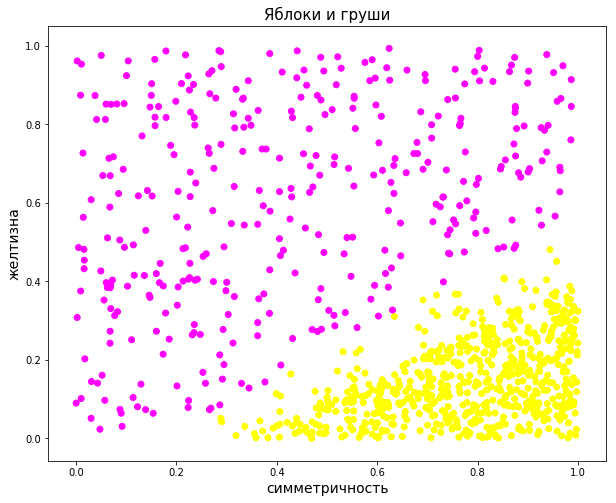

In [28]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

---

### Задача 1

1. Как видно по рисунку - качество не идеальное (даже перцептрон на нумпае лучше :). Добейтесь идеального качества (или очень близкого к идеальному), путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации);
2. Используйте функцию потерь `torch.nn.NLLLoss()` (== LogLoss) или `torch.nn.CrossEntropy()`, сделайте вывод о работе нейрона.

In [0]:
# Ваш код здесь (можно создавать много ячеек)

---

Круто. Нейрон работет, отличает яблоки от груш (Вы ведь этого добились, правда?). Но так ли он силён? Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

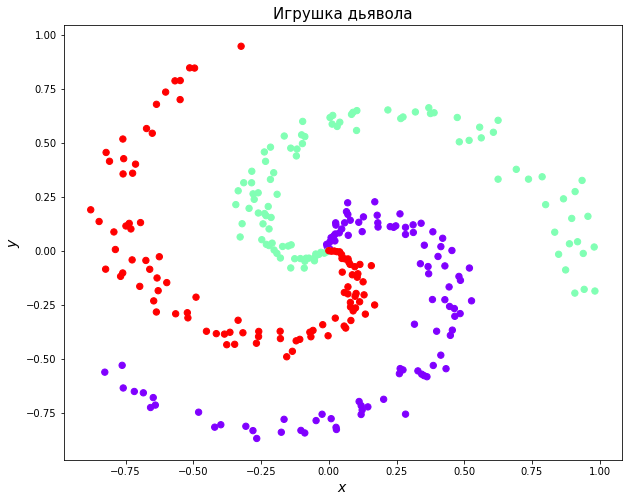

In [30]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear
import numpy as np
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable() (без этого градиенты не посчитать):

In [31]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [32]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


В атаку, наш славный нейрон с сигмоидой (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [37]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [34]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

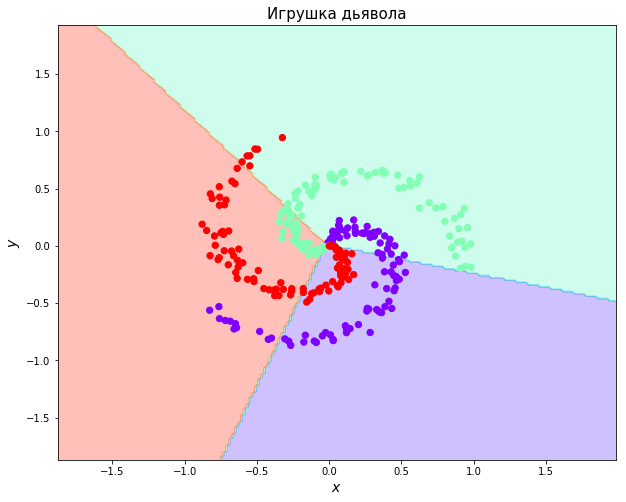

In [35]:
# Отрисовочна магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

---

### Задача 2

Меняя все известные Вам способы улучшения нейросети, постарайтесь добиться лучшего качества здесь. (**архитектуру менять нельзя**, мы же хотим добиться победы одним нейроном (слоем)).

In [0]:
# Ваш код здесь (можно (и нужно) создавать несколько ячеек)

---

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*